In [ ]:
# ---------------------- IMPORT THE LIBRARIES ----------------------
from math import *
import numpy as np
# from scipy.optimize import fsolve
import matplotlib
from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

print("Sucess!")

Sucess!


In [ ]:
# ---------------------- DEFINE PHYSICAL PARAMETERS ----------------------
# Natural Constants
g           = 9.81 #[m/s^2] (gravity)
rho         = 1.225 #[kg/m^3] (Mass density of air)
m_person    = 112 #[kg] (Use 95 percentile of heaviest people)
FoS         = 10 #[] (Client wants FoS 10)
k_ic        = 56E6 #[Pa*m^(1/2)]
Sy          = 310E6 #[Pa]
a           = 4E-3 #[m] (Smallest detectable crack)

# Machine Dimensional Parameters
max_height  = 38 #[m] (max height of the seats above the ground)
l_pendulum  = 25 #[m] (length of the pendulum arm - seats from pendulum axis)
theta_beam  = 25 #[deg] (angle of beam A wrt pendulum axis)
l_beam      = 0.812 #[m] (length of beam A)
n_seats     = 5 #[] (number of seats per bank/row)
m_seat      = m_person #[kg] (Assume seat weighs about as much as occupant)
m_seat_row  = (m_seat + m_person) * n_seats # [kg] (total mass of bank/row)
r_seat_row  = 5 #[m] (Distance from bank to pendulum axis) <-- This number needs to be determined more accurately

# Machine Dynamic Parameters (Refer to technical report for axis1 and axis2 definitions)
v_1_max = sqrt(2*max_height*g)
omega_1_max = v_1_max/l_pendulum #[rad/s] (Estimated from video, agrees with ~90km/h as advertised)
omega_2_max = 2*pi/3.5 #[rad/s] (Estimated from video ~ 1 rev in 3.5 [s])
t_max_rotation = 3.5 #[s] (Estimated from video)

print("Physical parameters set!")
print("omega_1_max = %0.4f " % (omega_1_max))
print("omega_2_max = %0.4f " % (omega_2_max))



Physical parameters set!
omega_1_max = 1.0922 
omega_2_max = 1.7952 


In [ ]:
# ---------------------- COMPUTE CENTRIPITAL FORCE AXIS 1 ----------------------

# Compute the centripital force from spinning about the pendulum pivot
# Fc = m*v^2/r = m*e_h*omega_1_max^2
F_c_1 = m_seat_row * l_pendulum * omega_1_max**2
print("F_c_1 = %0.4f [kN]" % (F_c_1/1000))


F_c_1 = 33.4011 [kN]


In [ ]:
# ---------------------- COMPUTE CENTRIPITAL FORCE AXIS 2 ----------------------

# Compute the centripital force from spinning about the pendulum axis
# Fc = m*v^2/r = m*e*omega**2
F_c_2 = m_seat_row * r_seat_row * (3 * omega_2_max)**2
print("F_c_2 = %0.4f [kN]" % (F_c_2 /1000))

F_c_2 = 162.4255 [kN]


In [ ]:
# ---------------------- COMPUTE FORCE OF GRAVITY ----------------------

# This is as simple as it sounds
F_g = m_seat_row * g
print("F_g = %0.4f [kN]" % (F_g/1000))


F_g = 10.9872 [kN]


In [ ]:
# ---------------------- TOTAL LOADING WITH FoS ----------------------
# Compute F_1 and F_2
F_1 = F_c_1 + F_g
F_2 = F_c_2

F_1 *= FoS
F_2 *= FoS

print("F_1        = %0.4f [kN]" % (F_1/1000))
print("F_2        = %0.4f [kN]" % (F_2/1000))

# Compute axial and bending components
F_axial   = F_1 * cos(radians(theta_beam)) + F_2 * sin(radians(theta_beam))
F_bending = F_1 * sin(radians(theta_beam)) + F_2 * cos(radians(theta_beam))

print("F_axial    = %0.4f [kN]" % (F_axial/1000))
print("F_bending  = %0.4f [kN]" % (F_bending/1000))

F_1        = 443.8829 [kN]
F_2        = 1624.2549 [kN]
F_axial    = 1088.7343 [kN]
F_bending  = 1659.6679 [kN]


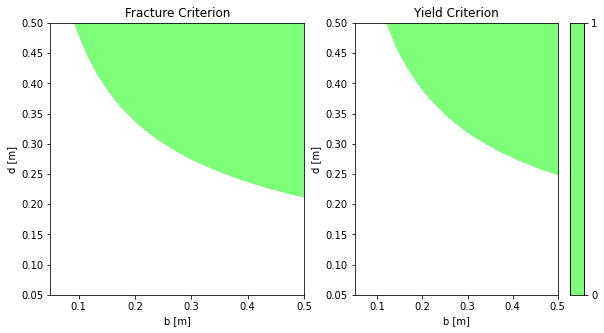

In [ ]:
# ---------------------- PLOT THE SAFE REGIONS ----------------------
%matplotlib inline
fig = plt.figure(figsize=(10, 5))  # Create figure with dim 8x4 [in]
ax1 = fig.add_subplot(1, 2, 1)    # Create first subplot for fracture
ax2 = fig.add_subplot(1, 2, 2)    # Create second subplot for yield

# Make data
b_values = np.linspace(0.05, 0.5, 256) # Refer to FBD for definition of b, d
d_values = np.linspace(0.05, 0.5, 256)
# Initialize empty 2D arrays for fracture and yield
k_values = np.zeros((len(b_values), len(d_values)))
yield_values = np.zeros((len(b_values), len(d_values)))

# This is used for plotting
X, Y = np.meshgrid(b_values, d_values)

# Use a for loop to compute stress values for all possible geometric configurations
for i, b in enumerate(b_values):
  for j, d in enumerate(d_values):
    
    # Compute stress and beta values
    sigma_nom_tension = F_axial / (b*d)
    sigma_nom_bending = (F_bending * b/2) / (1/12*d*b**3)
    beta_tension = 13.812*(a/b)**3 - 3.3862*(a/b)**2 + 2.0947*a/b + 0.9778
    beta_bending = 4.4563*(a/b)**2 - 1.344*a/b + 1.1272

    # k = beta * sigma_nom * sqrt(pi * a)
    k_values[i, j] = (sigma_nom_tension*beta_tension + sigma_nom_bending*beta_bending) * sqrt(pi*a)

    # Check yielding (F/A + Mc/I)
    sigma = (F_axial / (d*(b-a)**2)) + ((F_bending*l_beam*(b/2)) / (1/12 * d * (b-a)**3))
    # print("Stress = %0.4f [MPa]" % (sigma/1E6))
    yield_values[i, j] = sigma

# print(yield_values.min()/1E6)

# Normalize values in the fracture and yield matrix
k_values      /= k_ic
yield_values  /= Sy

# Plot the surface using contourf
cs = ax1.contourf(X, Y, k_values, [0, 1], cmap=cm.jet)
cs = ax2.contourf(X, Y, yield_values, [0, 1], cmap=cm.jet)

# Customize the plot
#ax.view_init(elev=90, azim=0)
ax1.set_title("Fracture Criterion")
ax1.set_xlabel("b [m]")
ax1.set_ylabel("d [m]")

ax2.set_title("Yield Criterion")
ax2.set_xlabel("b [m]")
ax2.set_ylabel("d [m]")

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)
cbar = fig.colorbar(cs)
plt.show()

In [ ]:
# ---------------------- COMPUTE FORCE FROM ANGULAR ACCELERATION ----------------------

# Compute approximate moment of inertia for the seat
I_pendulum_axis = m_seat_row * r_seat_row**2 #[kg*m^2] (Approximate as point mass)
print("I_pendulum_axis = %0.4f [kg*m^2]" % I_pendulum_axis)

# Compute required torque
angular_accel = omega_2_max / t_max_rotation #[rad/s^2]
print("angular_accel = %0.4f [rad/s^2]" % angular_accel)

Torque = I_pendulum_axis * angular_accel
print("Torque = %0.4f [Nm]" % Torque)

# Compute the force acting on the A Beam (T=F*d)
F = Torque / r_seat_row
print("F = %0.4f [kN]" % (F/1000))
print("This is pretty negligible compared to contributions from other loadings")

I_pendulum_axis = 28000.0000 [kg*m^2]
angular_accel = 0.5129 [rad/s^2]
Torque = 14361.5664 [Nm]
F = 2.8723 [kN]
This is pretty negligible compared to contributions from other loadings


In [ ]:
# ---------------------- COMPUTE DRAG FORCE FROM AIR RESISTANCE ----------------------

# Estimate force of air resistance drag at theta = 0
v = 20 #[m/s] (Max velocity, 20m/s is probably an overestimate)
A = 1*1.5 #[m/s] (Bulk frontal area)
C_d = 0.9 #[] (Coefficient of drag, 0.9 is very high)

F_d = 1/2 * C_d * rho * A * v**2
print("Max drag force = %0.4f [N]" % F_d)
print("This is pretty negligible compared to contributions from other loadings")

Max drag force = 330.7500 [N]
This is pretty negligible compared to contributions from other loadings


In [ ]:
# Dump some random code snippets here that didn't get used

# surf = ax.plot_surface(X, Y, k_values, cmap=cm.coolwarm, linewidth=0, antialiased=False) <-- This makes a 3D surface
# ax1.pcolormesh(X, Y, k_values, cmap=cm.binary) <-- This makes a 2D colourmapped surface
# ax2.pcolormesh(X, Y, yield_values, cmap=cm.coolwarm) <-- This makes a 2D colourmapped surface